In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [12]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [14]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [17]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [22]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [24]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

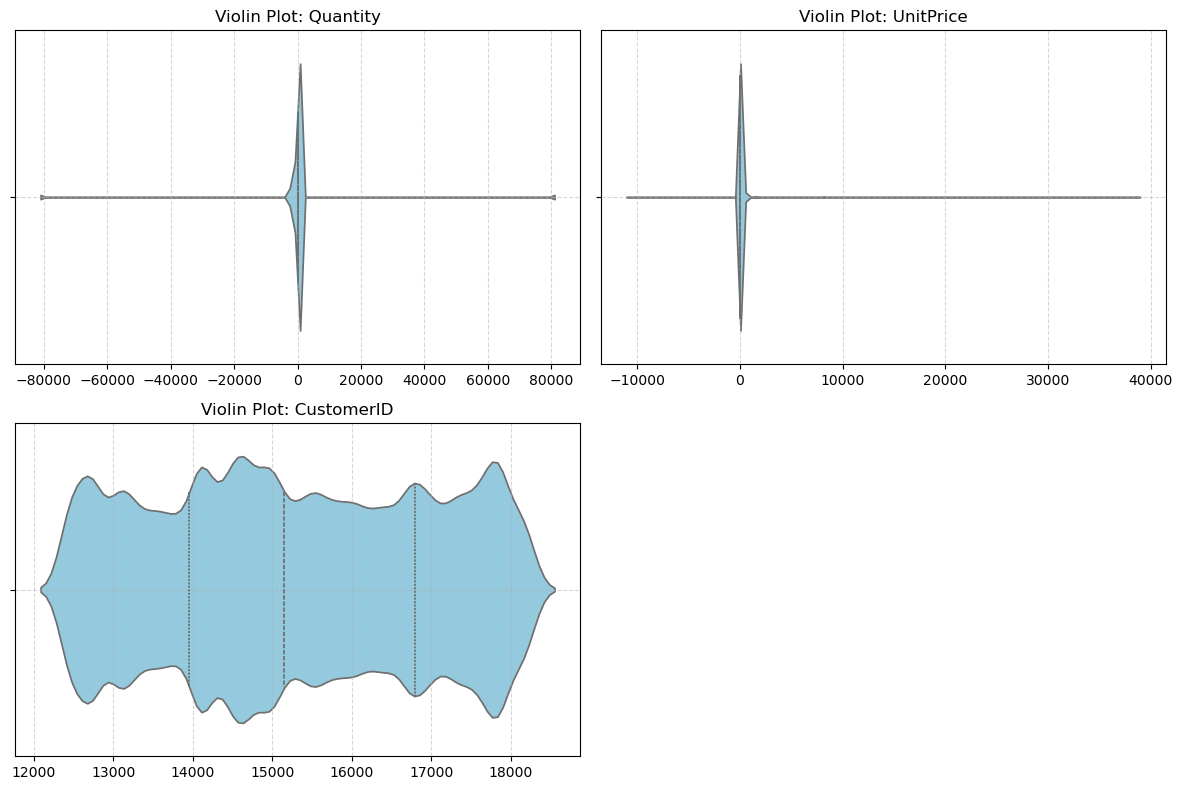

In [26]:
plt.figure(figsize=(12, 8))

# Loop through numerical columns to create subplots
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, (len(num_cols) + 1) // 2, i)
    sns.violinplot(x=df[col], color="skyblue", inner="quartile")
    plt.title(f"Violin Plot: {col}")
    plt.xlabel("")  # Remove x-label to keep it clean
    plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [28]:
df = df.dropna(subset=['CustomerID'])  # Drop rows with missing CustomerID
df = df.drop(columns=['Description'])  # Remove unnecessary text column

In [30]:
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]  # Ensure valid transactions

In [32]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [34]:
customer_data = df.groupby('CustomerID').agg({
    'TotalPrice': 'sum',      # Total spending
    'Quantity': 'sum',        # Total items purchased
    'InvoiceNo': 'nunique'    # Number of transactions
}).rename(columns={'InvoiceNo': 'NumTransactions'})

In [36]:
customer_data[['TotalPrice', 'Quantity']] = np.log1p(customer_data[['TotalPrice', 'Quantity']])

In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_data)

In [40]:
print("Preprocessed Data Shape:", X_scaled.shape)
customer_data.head()

Preprocessed Data Shape: (4338, 3)


,TotalPrice,Quantity,NumTransactions
CustomerID,,,
12346.0,11.253955,11.214735,1
12347.0,8.368925,7.807510,7
12348.0,7.494564,7.758761,4
12349.0,7.472245,6.448889,1
12350.0,5.815324,5.288267,1


Number of clusters (excluding noise): 4
Noise points (Cluster -1): 59


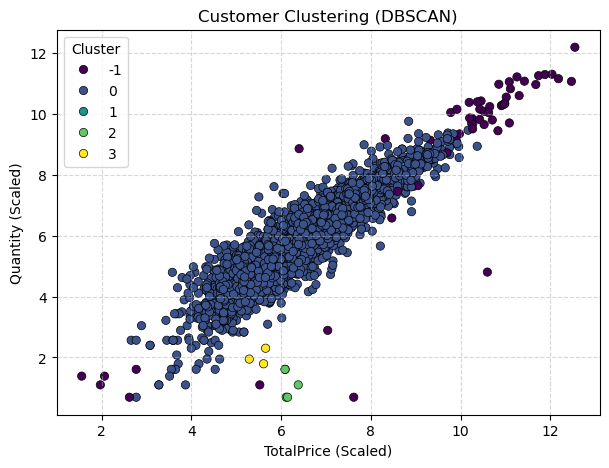

DBSCAN_Cluster
 0    4266
-1      59
 1       5
 2       5
 3       3
Name: count, dtype: int64


In [44]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # eps and min_samples may need tuning
customer_data['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

# Analyze DBSCAN results
print("Number of clusters (excluding noise):", len(set(customer_data['DBSCAN_Cluster'])) - 1)
print("Noise points (Cluster -1):", (customer_data['DBSCAN_Cluster'] == -1).sum())

# Plot results
plt.figure(figsize=(7,5))
sns.scatterplot(x=customer_data['TotalPrice'], y=customer_data['Quantity'], hue=customer_data['DBSCAN_Cluster'], palette="viridis", edgecolor="k")
plt.title("Customer Clustering (DBSCAN)")
plt.xlabel("TotalPrice (Scaled)")
plt.ylabel("Quantity (Scaled)")
plt.legend(title="Cluster")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Count customers in each cluster
print(customer_data['DBSCAN_Cluster'].value_counts())


In [48]:
# applying k mean so that we can compare both methods.....................................

In [52]:
from sklearn.cluster import KMeans

# Apply K-Means with an assumed best k (e.g., k=3, you may adjust based on elbow method)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
customer_data['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)


In [54]:
from sklearn.metrics import silhouette_score

# K-Means Silhouette Score
kmeans_silhouette = silhouette_score(X_scaled, customer_data['KMeans_Cluster'])
print(f"K-Means Silhouette Score: {kmeans_silhouette:.3f}")

# DBSCAN Silhouette Score (excluding noise)
dbscan_labels = customer_data['DBSCAN_Cluster']
valid_points = dbscan_labels != -1  # Exclude noise points (-1)
if valid_points.sum() > 1:  # Ensure enough valid samples
    dbscan_silhouette = silhouette_score(X_scaled[valid_points], dbscan_labels[valid_points])
    print(f"DBSCAN Silhouette Score (excluding noise): {dbscan_silhouette:.3f}")
else:
    print("Not enough valid clusters for Silhouette Score.")


K-Means Silhouette Score: 0.491
DBSCAN Silhouette Score (excluding noise): 0.376


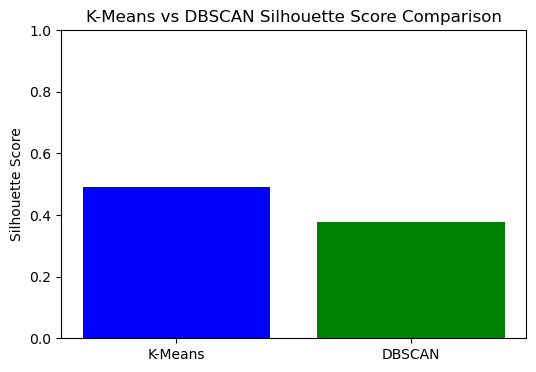

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Silhouette Scores
methods = ['K-Means', 'DBSCAN']
scores = [kmeans_silhouette, dbscan_silhouette] if valid_points.sum() > 1 else [kmeans_silhouette, 0]

# Plot
plt.figure(figsize=(6, 4))
plt.bar(methods, scores, color=['blue', 'green'])
plt.ylabel('Silhouette Score')
plt.title('K-Means vs DBSCAN Silhouette Score Comparison')
plt.ylim(0, 1)  # Silhouette score range
plt.show()


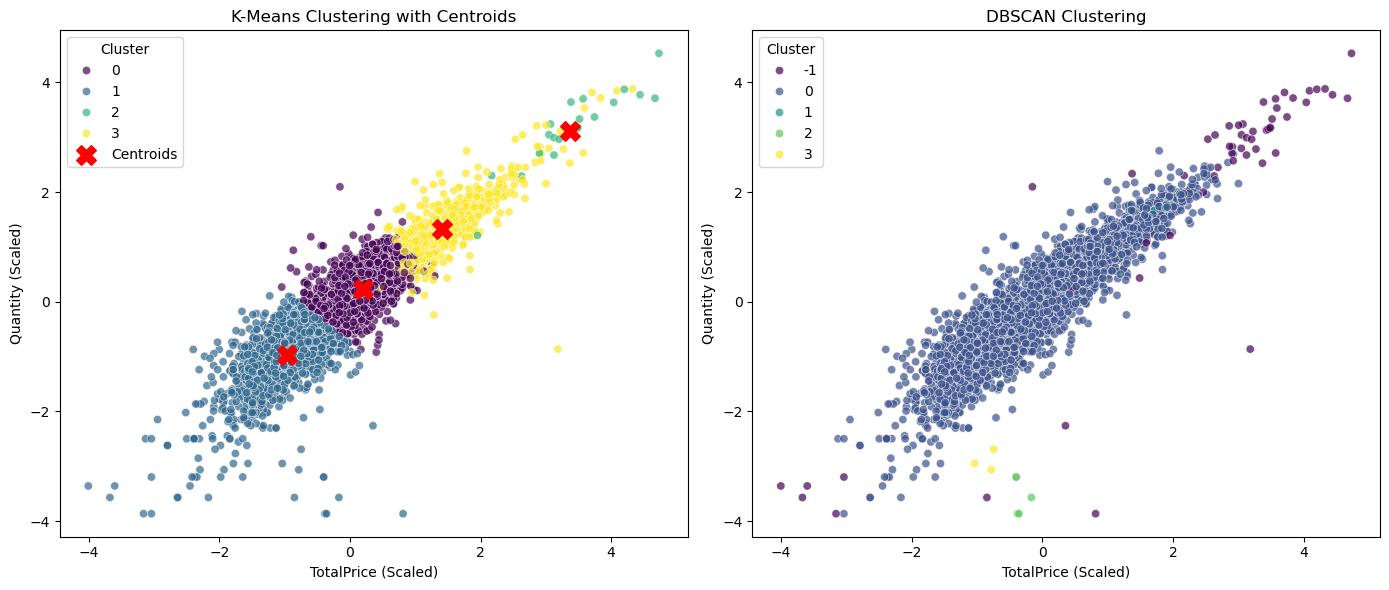

In [60]:
# Fit K-Means
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
customer_data['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

# Get Centroids
centroids = kmeans.cluster_centers_

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot K-Means Clusters with Centroids
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=customer_data['KMeans_Cluster'], palette="viridis", ax=axes[0], alpha=0.7)
axes[0].scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')  # Mark Centroids
axes[0].set_title("K-Means Clustering with Centroids")
axes[0].set_xlabel("TotalPrice (Scaled)")
axes[0].set_ylabel("Quantity (Scaled)")
axes[0].legend(title="Cluster")

# Plot DBSCAN Clusters
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=customer_data['DBSCAN_Cluster'], palette="viridis", ax=axes[1], alpha=0.7)
axes[1].set_title("DBSCAN Clustering")
axes[1].set_xlabel("TotalPrice (Scaled)")
axes[1].set_ylabel("Quantity (Scaled)")
axes[1].legend(title="Cluster")

# Display plots
plt.tight_layout()
plt.show()